<a href="https://colab.research.google.com/github/augustoputra/CSV-Transaction-Data-automatic-manipulation-/blob/main/Model_Evaluation_Case_1_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#install library
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, KFold

In [7]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :return df: <pandas DataFrame>  combined estimated coefficient and standard error of model estimate
    """
    coef = results.params
    std_err = results.bse

    df = pd.DataFrame(data = np.transpose([coef, std_err]),
                      index = coef.index,
                      columns=["coef","std err"])
    return df

class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """

    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None

    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()

    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :param n_fold: <int> Number of fold in k-fold CV
    :return df: <pandas DataFrame>  combined estimated coefficient and standard error of model estimate
    """
    kfold = KFold(n_splits = n_fold,
                  shuffle = True,
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()

    return (fold_train, fold_test)

In [9]:
df = pd.read_csv('Advertising.csv')

In [10]:
df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


They want to know

Which channels that contribute positively to overall sales.
If they have total advertising budget170$, and they have sales target to achieve 25 millions dollar revenue. How to distribute the total budget to each channels?
Help team sales to answer the questions and give recommendation to sales team utilizing regression model

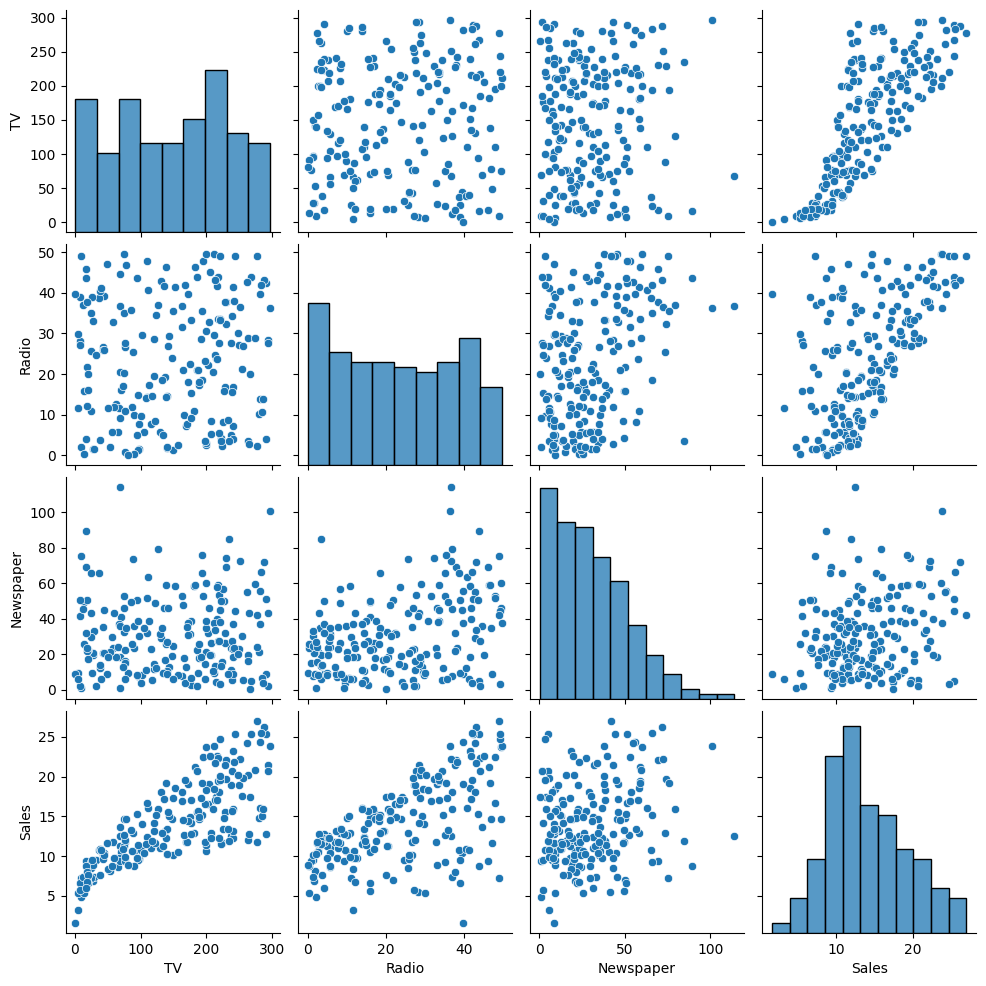

In [11]:
#EDA

sns.pairplot(df)
plt.show()

In [12]:
#create smf model
model = smf.ols(formula = 'Sales ~ TV + Radio + Newspaper', data = df)
result = model.fit()

In [14]:
print_coef_std_err(result)

,coef,std err
Intercept,2.938889,0.311908
TV,0.045765,0.001395
Radio,0.188530,0.008611
Newspaper,-0.001037,0.005871


so the formula for the sales (revenue) as follows
sales = 2.94 + 0.046xTV + 0.189xRadio - 0.001 x Newspaper

Newspaper correlates negatively for sales, hence we can erase newspaper from the factor.

sales = 2.94 + 0.046xTV + 0.189xRadio

25 = 2.94 + 0.046xTV + 0.189xRadio

25 - 2.94 = 0.046xTV + 0.189 x Radio

22.06 = 0.046xTV + 0.189 x (170 - TV)

22.06 = 32.13 + - 0.143xTV

TV = 10.07 / 0.143

In [38]:
TV = 10.07 / 0.143
TV

70.41958041958043

In [40]:
#hence
Radio = 170 - 70
Radio

100

100 Million for Radio and 70 Million for TV

# Evaluate Model Using K-fold cross validation

In [18]:
ols_all_media = StatsmodelsRegressor(smf.ols, 'Sales ~ TV + Radio + Newspaper')

In [21]:
#create K-Fold Splitter Object
kfold =KFold(n_splits = 5, shuffle =  True, random_state = 123)

In [34]:
#calculate performance for each model
score_ols_all_media  = cross_val_score(ols_all_media, df, df['Sales'], cv = kfold, scoring = 'r2')
df_kfold = pd.DataFrame(score_ols_all_media, columns = ['R_squared'])
df_kfold['Folds'] = [f"Folds {i+1}" for i in range(0, 5)]

In [35]:
df_kfold

,R_squared,Folds
0,0.928861,Folds 1
1,0.846030,Folds 2
2,0.854402,Folds 3
3,0.885496,Folds 4
4,0.913986,Folds 5


In [36]:
#mean of R squared
df_kfold['R_squared'].mean()

0.8857548804553106

The model use all media have good fit, it can explain 88.7% variance of sales. Let's build the model using whole data to infer the estimated coefficient from the model, and gain the insight from business prespective